In [1]:
!pip install -r requirements.txt --upgrade


Problem: How to improve public transportation in a growing city

Running comparison for gpt-3.5-turbo:
Standard COT Score: 57.06
Contrarian-enhanced COT Score: 62.24
Improvement: 5.18 points

Running comparison for gpt-4:
Standard COT Score: 52.01
Contrarian-enhanced COT Score: 52.47
Improvement: 0.47 points

Running comparison for gpt-4o:
Standard COT Score: 53.09
Contrarian-enhanced COT Score: 50.38
Improvement: -2.71 points

Problem: Develop a comprehensive plan to reverse global warming within 50 years

Running comparison for gpt-3.5-turbo:
Standard COT Score: 56.59
Contrarian-enhanced COT Score: 59.64
Improvement: 3.05 points

Running comparison for gpt-4:
Standard COT Score: 49.38
Contrarian-enhanced COT Score: 53.62
Improvement: 4.24 points

Running comparison for gpt-4o:
Standard COT Score: 49.37
Contrarian-enhanced COT Score: 55.17
Improvement: 5.80 points

Problem: What is the nature of consciousness?

Running comparison for gpt-3.5-turbo:
Standard COT Score: 54.96
Contraria

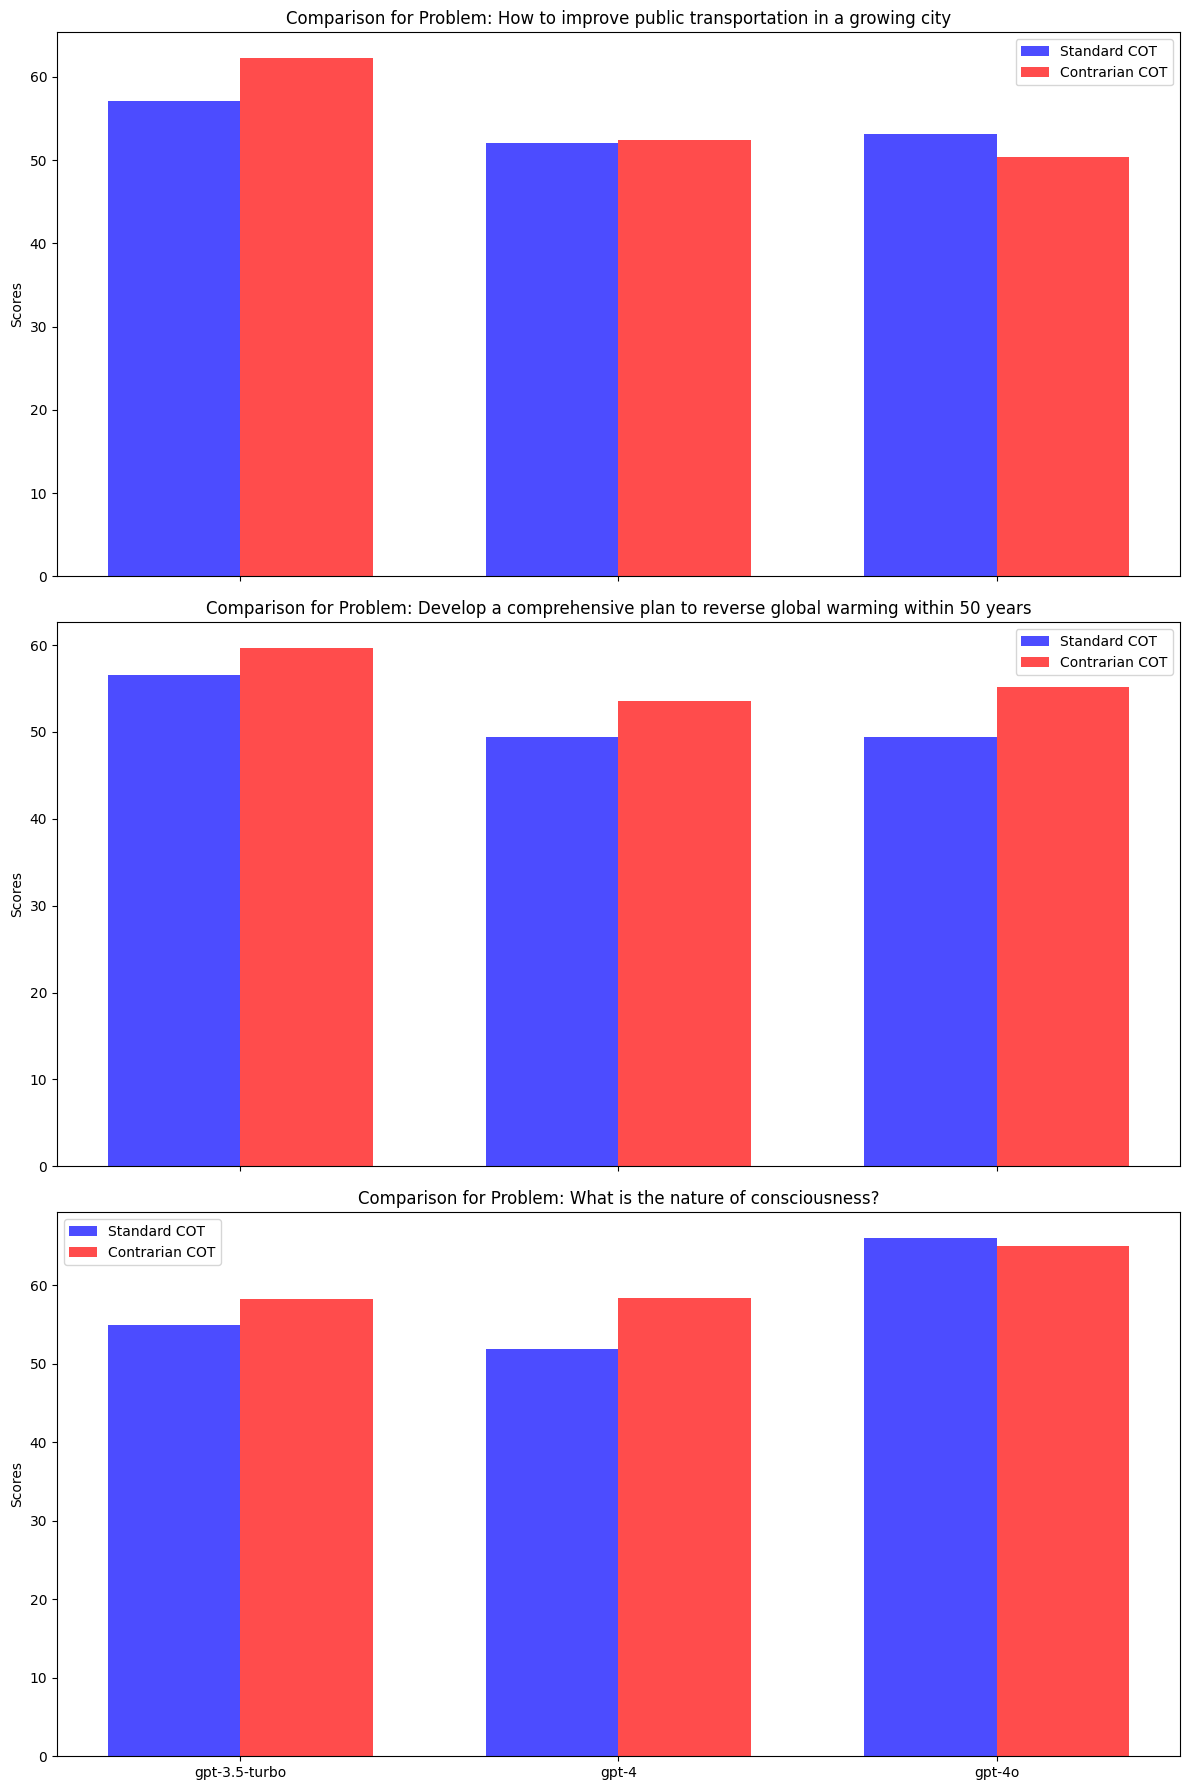

In [5]:
import openai
import os
from dotenv import load_dotenv
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Load environment variables
load_dotenv()

# Set up OpenAI API key
openai.api_key = os.getenv("OPENAI_API_KEY")

class Agent:
    def __init__(self, name, model):
        self.name = name
        self.model = model

    def think(self, problem):
        prompt = f"{self.name} is thinking about the problem: {problem}\n\nGenerate 5 detailed thoughts about approaching this problem:"
        response = openai.ChatCompletion.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are a helpful AI assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=200,
            n=1,
            temperature=0.7,
        )
        thoughts = response.choices[0].message['content'].strip().split("\n")
        return [thought.strip() for thought in thoughts if thought.strip()]

class ContrarianAgent(Agent):
    def critique(self, thought):
        prompt = f"Provide a contrarian perspective or critique for the following thought:\n\n{thought}\n\nContrarian critique:"
        response = openai.ChatCompletion.create(
            model=self.model,
            messages=[
                {"role": "system", "content": "You are a helpful AI assistant."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=100,
            n=1,
            temperature=0.7,
        )
        return response.choices[0].message['content'].strip()

class Scorer:
    def __init__(self):
        self.complexity_weight = 0.3
        self.diversity_weight = 0.3
        self.insightfulness_weight = 0.4

    def calculate_complexity(self, text):
        words = text.split()
        avg_word_length = sum(len(word) for word in words) / len(words)
        sentence_count = len(re.findall(r'\w+[.!?]', text)) or 1
        avg_sentence_length = len(words) / sentence_count
        return (avg_word_length * 0.5 + avg_sentence_length * 0.5) / 10  # Normalize to 0-1 scale

    def calculate_diversity(self, texts):
        all_words = [word.lower() for text in texts for word in text.split()]
        unique_words = set(all_words)
        return len(unique_words) / len(all_words)

    def calculate_insightfulness(self, text):
        insightful_keywords = ['innovative', 'creative', 'efficient', 'effective', 'sustainable', 'long-term', 'holistic', 'comprehensive', 'adaptable', 'scalable']
        word_count = len(text.split())
        keyword_count = sum(1 for word in text.lower().split() if word in insightful_keywords)
        return keyword_count / word_count

    def score_cot(self, thoughts, critiques=None):
        all_texts = thoughts + (critiques or [])
        complexity = sum(self.calculate_complexity(text) for text in all_texts) / len(all_texts)
        diversity = self.calculate_diversity(all_texts)
        insightfulness = sum(self.calculate_insightfulness(text) for text in all_texts) / len(all_texts)
        
        score = (
            complexity * self.complexity_weight +
            diversity * self.diversity_weight +
            insightfulness * self.insightfulness_weight
        ) * 100  # Scale to 0-100
        
        return score

def standard_cot(problem, model, scorer):
    agent = Agent("Standard Agent", model)
    thoughts = agent.think(problem)
    score = scorer.score_cot(thoughts)
    return score

def contrarian_cot(problem, model, scorer):
    agent = Agent("Main Agent", model)
    contrarian = ContrarianAgent("Contrarian", model)
    thoughts = agent.think(problem)
    critiques = [contrarian.critique(thought) for thought in thoughts]
    score = scorer.score_cot(thoughts, critiques)
    return score

def run_comparison(problems):
    models = ["gpt-3.5-turbo", "gpt-4", "gpt-4o"]
    scorer = Scorer()
    results = {}

    for problem in problems:
        print(f"\nProblem: {problem}")
        problem_results = {}
        for model in models:
            print(f"\nRunning comparison for {model}:")
            standard_score = standard_cot(problem, model, scorer)
            contrarian_score = contrarian_cot(problem, model, scorer)
            problem_results[model] = {
                "Standard": standard_score,
                "Contrarian": contrarian_score
            }
            print(f"Standard COT Score: {standard_score:.2f}")
            print(f"Contrarian-enhanced COT Score: {contrarian_score:.2f}")
            print(f"Improvement: {contrarian_score - standard_score:.2f} points")
        results[problem] = problem_results

    return results

def plot_results(results):
    problems = list(results.keys())
    models = list(results[problems[0]].keys())
    
    fig, axs = plt.subplots(len(problems), 1, figsize=(12, 6*len(problems)), sharex=True)
    
    for i, problem in enumerate(problems):
        ax = axs[i] if len(problems) > 1 else axs
        
        standard_scores = [results[problem][model]["Standard"] for model in models]
        contrarian_scores = [results[problem][model]["Contrarian"] for model in models]

        x = range(len(models))
        width = 0.35

        ax.bar([i - width/2 for i in x], standard_scores, width, label='Standard COT', color='blue', alpha=0.7)
        ax.bar([i + width/2 for i in x], contrarian_scores, width, label='Contrarian COT', color='red', alpha=0.7)

        ax.set_ylabel('Scores')
        ax.set_title(f'Comparison for Problem: {problem}')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()

    plt.tight_layout()
    plt.show()

def main():
    problems = [
        "How to improve public transportation in a growing city",  # Easy question
        "Develop a comprehensive plan to reverse global warming within 50 years",  # Hard question
        "What is the nature of consciousness?"  # Ambiguous question
    ]
    results = run_comparison(problems)
    plot_results(results)

if __name__ == "__main__":
    main()